# Sprint 9 · Webinar 28 · Data Analytics práctico  
**Proyecto Sprint 9:** Experimento A/B en página de inicio (Landing Experiment)

> En esta sesión práctica resolveremos, paso a paso, el proyecto **"Landing Experiment"** usando los conceptos del **Webinar 27 (Teórico)**: formular preguntas medibles, revisar calidad de datos, y validar diferencias con pruebas estadísticas sencillas.


## Fecha
> Completa aquí la fecha de la sesión.


## Objetivo de la sesión práctica (100 min)

Al finalizar esta clase, podrás:

1. Cargar y validar un dataset de un **experimento A/B**.
2. Realizar un **EDA básico** para detectar problemas de calidad (tipos, duplicados, valores fuera de rango).
3. Comparar **métricas clave** entre las versiones **A** y **B**:
   - **Gasto promedio** (solo usuarios que convirtieron)
   - **Tasa de conversión** (usuarios que convierten / total)
4. Aplicar pruebas simples para tomar una decisión:
   - **t-test** para comparar promedios
   - **Chi-cuadrado** para comparar proporciones (conversiones)
5. Escribir conclusiones claras: **qué pasó, qué significa, y qué haría negocio**.


## Agenda sugerida (100 minutos)

1. Contexto del proyecto + checklist de entregables (5 min)  
2. **Actividad 0 (breakout rooms):** de pregunta de negocio a métrica (10 min)  
3. Ejercicio 1: cargar y entender el dataset (15 min)  
4. Ejercicio 2: revisión de calidad de datos (15 min)  
5. Ejercicio 3: gasto promedio (A vs B) + visualización (15 min)  
6. Ejercicio 4: prueba t para el gasto (15 min)  
7. Ejercicio 5: tasa de conversión (A vs B) + Chi-cuadrado (15 min)  
8. Ejercicio 6: segmentación rápida (región / dispositivo) (5 min)  
9. Reporte final + cierre (5 min)


## Contexto del negocio

Un equipo de producto probó dos versiones de la **página de inicio (landing page)**:

- **Versión A:** diseño actual  
- **Versión B:** nuevo diseño (hipótesis: mejora conversión y/o gasto)

El objetivo del experimento es responder preguntas como:

- ¿La versión B **convierte más** usuarios?
- Entre quienes convierten, ¿la versión B genera **más gasto**?

⚠️ Importante:
- **Conversión** suele ser una variable binaria (`0/1`).
- **Gasto** es numérica y suele tener mucha variabilidad.


## Dataset del proyecto

En el proyecto trabajaremos con un archivo tipo CSV llamado `landing_experiment_sintetico_40k.csv`.

Columnas típicas (pueden variar ligeramente según tu versión):
- `user_id` — identificador único del usuario  
- `date` — fecha en que el usuario participó en el experimento  
- `landing` — variante del experimento (`A` o `B`)  
- `converted` — si convirtió (1) o no (0)  
- `gasto` — gasto del usuario (normalmente 0 si no convirtió, o gasto positivo si convirtió)  
- Otras variables de segmentación: `region`, `dispositivo`, `traffic_source`, `user_type`, etc.

📌 **Checklist de entregables (lo que se espera en el proyecto):**
- Validación básica de datos (tipos, duplicados, rango de fechas)
- Comparación de métricas A vs B
- Pruebas estadísticas simples + interpretación
- Conclusión de negocio y recomendación


---

# Actividad 0 · Calentamiento (10 min)

Tus estudiantes aún están iniciando, así que **no empezamos** con fórmulas.

### Instrucciones (breakout rooms, 3–4 personas)

1) Lean la pregunta:  
   **“¿La versión B es mejor que la A?”**

2) Conviertan la pregunta en **2 preguntas medibles** (métrica + comparación).  
   Usa esta plantilla:

- Métrica 1: ___________  
  Comparación: A vs B  
  “B es mejor si _________”

- Métrica 2: ___________  
  Comparación: A vs B  
  “B es mejor si _________”

3) Definan qué columnas del dataset usarían para cada métrica.

### Pista
En experimentos A/B casi siempre aparecen:
- una métrica de **conversión** (proporción)
- una métrica de **valor** (promedio/mediana de gasto)

### Puesta en común (2 min)
Cada equipo comparte sus 2 métricas.


In [1]:
# ============================================================
# Imports y configuración (ejecuta esta celda primero)
# ============================================================
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import chi2_contingency

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

RANDOM_SEED = 42


---

# Ejercicio 1 · Cargar y explorar el dataset (15 min)

**Meta:** cargar datos, ver estructura y entender qué representa cada columna.

### 1.1 Cargar datos

Usaremos el archivo `landing_experiment_sintetico_40k.csv`. Disponible en GitHub:


In [2]:
# Tu turno: intenta cargar el dataset

df = pd.read_csv("https://raw.githubusercontent.com/ljpiere/tpdata_python/refs/heads/main/DA/datasets/landing_experiment_sintetico_40k.csv")

df.head()


,user_id,date,landing,region,dispositivo,traffic_source,user_type,converted,gasto
0,825db3f6-4232-44dc-bf70-37c413362d91,2026-02-22,A,Sur,Mobile,Ads,Nuevo,0,0.00
1,42c32e9f-b626-4416-88e8-092b1fbb96d2,2026-02-13,A,Norte,Desktop,Ads,Nuevo,1,57.66
2,85eee9b6-ed60-4124-bee0-e9f02d530335,2026-02-25,A,Sur,Desktop,Organic,Recurrente,0,0.00
3,873fcb56-7fed-4b8c-a0b3-ff94bcd10acc,2026-02-20,A,Sur,Mobile,Organic,Nuevo,0,0.00
4,e7cf8f07-f65b-4686-b733-daf99dab571e,2026-02-03,B,Centro,Mobile,Organic,Recurrente,1,63.26


In [3]:
# Vista general: dimensiones y tipos
print("Dimensiones (filas, columnas):", df.shape)
df.info()


Dimensiones (filas, columnas): (40000, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         40000 non-null  object 
 1   date            40000 non-null  object 
 2   landing         40000 non-null  object 
 3   region          39851 non-null  object 
 4   dispositivo     40000 non-null  object 
 5   traffic_source  39762 non-null  object 
 6   user_type       40000 non-null  object 
 7   converted       40000 non-null  int64  
 8   gasto           40000 non-null  float64
dtypes: float64(1), int64(1), object(7)
memory usage: 2.7+ MB


✍️ **Mini-análisis (texto en Markdown):**
- ¿Cuántas filas y columnas hay?
- ¿Qué columnas parecen ser numéricas? ¿cuáles categóricas?
- ¿Qué columna representa la variante (A/B)? ¿y la conversión?

> Escribe tus observaciones debajo de este bloque.


### 1.2 Diccionario de datos (para la sesión)

Completa este diccionario con lo que observes:

- `user_id`: __________  
- `date`: __________  
- `landing`: __________  
- `converted`: __________  
- `gasto`: __________  
- otras columnas: __________


---

# Ejercicio 2 · Revisión de calidad de datos (15 min)

**Meta:** asegurar que el experimento está bien formado.

Checklist:
1. ¿Hay valores faltantes?
2. ¿Hay `user_id` duplicados?
3. ¿`landing` solo tiene A y B?
4. ¿`converted` solo tiene 0 y 1?
5. ¿`gasto` tiene valores negativos? (no debería)


In [4]:
# 2.1 Valores faltantes por columna
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)
missing_pct.to_frame("missing_%").round(2)


,missing_%
traffic_source,0.60
region,0.37
user_id,0.00
landing,0.00
date,0.00
dispositivo,0.00
user_type,0.00
converted,0.00
gasto,0.00


In [5]:
# 2.2 Duplicados en user_id
# Si cada usuario aparece una sola vez, no debería haber duplicados.
duplicados_user = df["user_id"].duplicated().sum()
print("Duplicados en user_id:", duplicados_user)


Duplicados en user_id: 0


In [6]:
# 2.3 Valores únicos en las variables clave
print("Valores en landing:", sorted(df["landing"].dropna().unique()))
print("Valores en converted:", sorted(df["converted"].dropna().unique()))

# Revisión rápida de gasto
print("Gasto mínimo:", df["gasto"].min())
print("Gasto máximo:", df["gasto"].max())
df["gasto"].describe()


Valores en landing: ['A', 'B']
Valores en converted: [np.int64(0), np.int64(1)]
Gasto mínimo: -97.49
Gasto máximo: 383.21


,gasto
count,40000.000000
mean,8.902854
std,26.006051
min,-97.490000
25%,0.000000
50%,0.000000
75%,0.000000
max,383.210000


### 2.4 Fecha: rango temporal del experimento (opcional pero recomendado)

Un experimento A/B normalmente tiene un rango de fechas definido.
Revisemos mínimos y máximos.


In [7]:
# Si date viene como texto, primero lo convertimos a datetime.
# errors='coerce' convierte valores inválidos en NaT (para detectar problemas).
df["date"] = pd.to_datetime(df["date"], errors="coerce")

print("Fecha mínima:", df["date"].min())
print("Fecha máxima:", df["date"].max())

# ¿Hay fechas inválidas?
print("Fechas inválidas (NaT):", df["date"].isna().sum())


Fecha mínima: 2026-02-01 00:00:00
Fecha máxima: 2026-02-28 00:00:00
Fechas inválidas (NaT): 0


✍️ **Decisiones (documentación):**
Si encontraste problemas, documenta qué harías. Ejemplos:

- Si hay duplicados en `user_id`: ¿los eliminas? ¿por qué?
- Si hay gasto negativo: ¿filtras? ¿lo marcas como error?
- Si `date` tiene NaT: ¿remueves esas filas?

> Nota: En esta clase **no** buscamos “perfección”, buscamos hábitos sanos: revisar y documentar.


### 2.5 Limpieza mínima (para poder analizar)

Aplicaremos una limpieza **muy simple** y conservadora:

- Remover filas con `landing` faltante
- Asegurar `converted` como entero 0/1 (si es posible)
- Reemplazar `gasto` faltante por 0 (si existe), porque suele significar “no gastó”

⚠️ Si tu dataset real es distinto, ajusta con criterio y documenta.


In [8]:
# Copia de trabajo para no dañar el df original si lo necesitas
data = df.copy()

# 1) Eliminar filas sin landing (sin variante, no se puede comparar)
data = data.dropna(subset=["landing"])

# 2) Asegurar converted como 0/1 entero cuando sea posible
#    Si hay valores extraños, quedarán como NaN y luego se revisan.
data["converted"] = pd.to_numeric(data["converted"], errors="coerce")

# 3) Gasto: convertir a numérico y llenar faltantes con 0
data["gasto"] = pd.to_numeric(data["gasto"], errors="coerce")
data["gasto"] = data["gasto"].fillna(0)

print("Dimensiones después de limpieza mínima:", data.shape)
data[["landing", "converted", "gasto"]].head()


Dimensiones después de limpieza mínima: (40000, 9)


,landing,converted,gasto
0,A,0,0.00
1,A,1,57.66
2,A,0,0.00
3,A,0,0.00
4,B,1,63.26


---

# Ejercicio 3 · Gasto promedio (A vs B) (15 min)

**Pregunta:** Entre quienes convirtieron (`converted = 1`), ¿el gasto promedio es diferente en A vs B?

### Paso 1: filtrar solo convertidos
### Paso 2: calcular promedio y tamaño de muestra (n)
### Paso 3: visualizar (histograma simple o boxplot)


In [9]:
# 3.1 Filtrar convertidos
conv = data[data["converted"] == 1].copy()

print("Usuarios que convirtieron:", conv.shape[0])
print("Por variante:")
print(conv["landing"].value_counts())
conv.head()


Usuarios que convirtieron: 5255
Por variante:
landing
B    2903
A    2352
Name: count, dtype: int64


,user_id,date,landing,region,dispositivo,traffic_source,user_type,converted,gasto
1,42c32e9f-b626-4416-88e8-092b1fbb96d2,2026-02-13,A,Norte,Desktop,Ads,Nuevo,1,57.66
4,e7cf8f07-f65b-4686-b733-daf99dab571e,2026-02-03,B,Centro,Mobile,Organic,Recurrente,1,63.26
22,e910903c-a798-4fc2-84a3-be03d0d3346f,2026-02-28,A,Sur,Mobile,Organic,Nuevo,1,93.88
23,a50dfc89-e49c-4a97-97f5-805943ee5702,2026-02-26,A,Sur,Mobile,Referral,Nuevo,1,44.05
31,983038e8-df74-4662-a06d-b43c5e87f018,2026-02-28,A,Sur,Desktop,Email,Nuevo,1,17.98


In [10]:
# 3.2 Resumen por variante: tamaño (n) y gasto promedio
resumen_gasto = conv.groupby("landing")["gasto"].agg(["count", "mean", "median", "std"]).round(2)
resumen_gasto.rename(columns={"count":"n", "mean":"gasto_promedio", "median":"gasto_mediana", "std":"gasto_std"})


,n,gasto_promedio,gasto_mediana,gasto_std
landing,,,,
A,2352,67.74,61.06,32.90
B,2903,67.79,60.87,34.95


<Figure size 640x480 with 0 Axes>

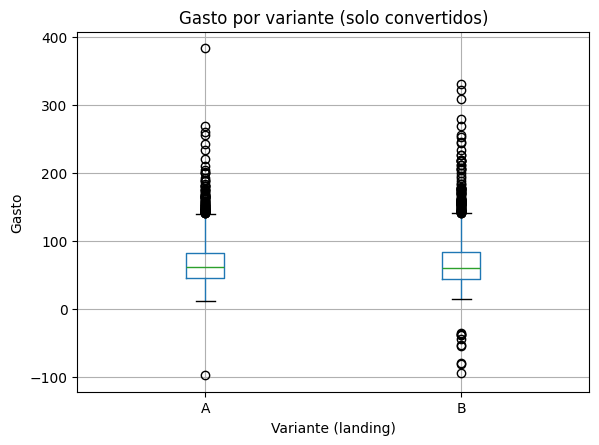

In [11]:
# 3.3 Visualización simple: boxplot del gasto por variante (solo convertidos)
plt.figure()
conv.boxplot(column="gasto", by="landing")
plt.title("Gasto por variante (solo convertidos)")
plt.suptitle("")  # quita el título automático
plt.xlabel("Variante (landing)")
plt.ylabel("Gasto")
plt.show()


✍️ **Interpretación visual:**
- ¿Ves una diferencia clara entre A y B?
- ¿Hay muchos valores extremos (outliers)?
- ¿La distribución parece “rara” (muy sesgada)?

> Escribe 2–3 frases.


---

# Ejercicio 4 · Prueba t para comparar gasto promedio (15 min)

Ahora pasamos de “ver diferencias” a **validar con una prueba estadística simple**.

### ¿Qué estamos comparando?
- Dos grupos independientes (usuarios que vieron A vs usuarios que vieron B)
- Variable numérica: `gasto`
- Solo usuarios que convirtieron (porque quienes no convierten suelen tener gasto 0)

### Prueba elegida: t-test (Welch)
Usamos `ttest_ind(..., equal_var=False)` porque **no asumimos varianzas iguales** (es más seguro).

📌 Interpretación (regla simple):
- Si `p_value < 0.05`: evidencia de diferencia (al nivel 5%)
- Si `p_value >= 0.05`: no hay evidencia suficiente para afirmar diferencia

⚠️ Esto no significa “B es mejor” automáticamente: hay que mirar también el **tamaño** de la diferencia (promedios).


In [12]:
# 4.1 Separar gasto por variante (solo convertidos)
gasto_A = conv[conv["landing"] == "A"]["gasto"]
gasto_B = conv[conv["landing"] == "B"]["gasto"]

print("n A:", gasto_A.shape[0], "| promedio A:", round(gasto_A.mean(), 2))
print("n B:", gasto_B.shape[0], "| promedio B:", round(gasto_B.mean(), 2))


n A: 2352 | promedio A: 67.74
n B: 2903 | promedio B: 67.79


In [13]:
# 4.2 t-test de Welch (varianzas no asumidas iguales)
t_stat, p_value = stats.ttest_ind(gasto_A, gasto_B, equal_var=False)

print("t_stat:", round(t_stat, 4))
print("p_value:", round(p_value, 6))


t_stat: -0.0455
p_value: 0.963713


### 4.3 Conclusión en lenguaje de negocio

Completa:

- Promedio A: ______  
- Promedio B: ______  
- p-value: ______

**Conclusión (1–2 frases):**  
“Con un nivel de significancia del 5%, _________ evidencia de que el gasto promedio entre convertidos sea diferente entre A y B.  
En términos prácticos, B tiene un gasto promedio _________ que A (mayor/menor/similar).”


---

# Ejercicio 5 · Tasa de conversión (A vs B) + Chi-cuadrado (15 min)

**Pregunta:** ¿La versión B convierte una proporción distinta de usuarios que la A?

### 5.1 Tasa de conversión
Definición:
\[
	ext{conversion\_rate} = \frac{\#converted=1}{\#total}
\]

### 5.2 Prueba estadística: Chi-cuadrado (2×2)

Construimos una tabla de contingencia:

| landing | converted=0 | converted=1 |
|---|---:|---:|
| A | ... | ... |
| B | ... | ... |

Luego aplicamos `chi2_contingency`.  
Regla simple:
- `p_value < 0.05` → evidencia de que la conversión depende de la variante (A/B)


In [14]:
# 5.1 Tasa de conversión por variante
conv_rate = data.groupby("landing")["converted"].mean().round(4)
counts = data["landing"].value_counts()

resumen_conv = pd.DataFrame({
    "n_total": counts,
    "conversion_rate": conv_rate
}).sort_index()

resumen_conv


,n_total,conversion_rate
landing,,
A,19482,0.1207
B,20518,0.1415


In [15]:
# 5.2 Tabla de contingencia 2x2 (landing vs converted)
tabla = pd.crosstab(data["landing"], data["converted"])
tabla


converted,0,1
landing,,
A,17130,2352
B,17615,2903


In [16]:
# 5.3 Prueba Chi-cuadrado
chi2, p_value, dof, expected = chi2_contingency(tabla)

print("chi2:", round(chi2, 4))
print("p_value:", round(p_value, 6))
print("grados de libertad (dof):", dof)

# (Opcional) frecuencias esperadas si no hubiera relación
expected_df = pd.DataFrame(expected, index=tabla.index, columns=tabla.columns).round(2)
expected_df


chi2: 37.555
p_value: 0.0
grados de libertad (dof): 1


converted,0,1
landing,,
A,16922.55,2559.45
B,17822.45,2695.55


### 5.4 Conclusión de conversión (lenguaje de negocio)

Completa:

- Conversion rate A: ______  
- Conversion rate B: ______  
- p-value: ______

**Conclusión (1–2 frases):**  
“Con un nivel de significancia del 5%, _________ evidencia de que la tasa de conversión sea diferente entre A y B.  
En términos prácticos, B convierte _________ que A (más/menos/similar).”


---

# Ejercicio 6 · Segmentación rápida (5 min)

A veces, el efecto cambia por segmento (región, dispositivo, fuente de tráfico).

**Meta:** calcular la tasa de conversión por `landing` dentro de **un** segmento.

Elige una columna de segmentación que exista en tu dataset, por ejemplo:
- `region`
- `dispositivo`
- `traffic_source`
- `user_type`

Si tu dataset no tiene esas columnas, puedes saltar este ejercicio.


In [17]:
# Tu turno: revisa qué columnas de segmentación existen
data.columns


Index(['user_id', 'date', 'landing', 'region', 'dispositivo', 'traffic_source', 'user_type', 'converted', 'gasto'], dtype='object')

In [18]:
# Ejemplo: segmentación por dispositivo (cambia 'dispositivo' por la columna que tengas)
segment_col = "dispositivo"  # <-- cambia aquí si aplica

if segment_col in data.columns:
    seg = data.groupby([segment_col, "landing"])["converted"].mean().round(4).reset_index()
    seg = seg.pivot(index=segment_col, columns="landing", values="converted").sort_values(by="B", ascending=False)
    seg.rename(columns={"A":"conv_rate_A", "B":"conv_rate_B"})
else:
    print(f"No existe la columna '{segment_col}' en este dataset. Cambia segment_col por otra columna o salta el ejercicio.")


✍️ **Mini-insight (1 frase):**
- ¿En qué segmento parece que B mejora más (si es que mejora)?


---

# Reporte final (5 min)

Completa este mini-reporte. La idea es practicar cómo comunicar resultados.

## 1) ¿Qué medimos?
- Métrica 1 (conversión): _________  
- Métrica 2 (gasto en convertidos): _________  

## 2) Resultados principales
- Conversión A vs B: _________  
- Gasto promedio (convertidos) A vs B: _________  

## 3) Evidencia estadística (regla simple con p-value)
- p-value conversión (Chi-cuadrado): _________  
- p-value gasto (t-test): _________  

## 4) Conclusión de negocio (decisión)
Elige una:
- ✅ Recomendar B
- ❌ Mantener A
- 🟡 No hay evidencia suficiente → recolectar más datos / extender experimento

Justifica en 2–3 frases: _________

## 5) Limitaciones (menciona 1–2)
Ejemplos: duración del experimento, sesgo por fuente de tráfico, estacionalidad, usuarios repetidos, etc.


## Takeaways de la sesión práctica

- Un A/B test se resuelve con un flujo ordenado: **cargar → validar → medir → comparar → decidir**.
- No basta con “ver diferencias”: usamos pruebas simples para evaluar si la diferencia podría ser azar.
- La decisión final debe considerar:
  - **tamaño del efecto** (diferencia real en métricas)
  - **evidencia estadística** (p-value)
  - **contexto del negocio** (costos, riesgos, impacto)


## Cierre y próximos pasos

Para el entregable del proyecto:
- Mantén tu notebook **limpio** (Markdown + resultados).
- Documenta decisiones de limpieza y supuestos.
- Termina con una **recomendación clara** (y limitaciones).

Siguiente nivel (para más adelante):
- intervalos de confianza para métricas
- pruebas no paramétricas si hay distribuciones muy sesgadas
- métricas adicionales (retención, click-through, etc.)

Ayuda en camino:
- Recuerda que puedes agendar sesiones 1:1 para revisar futuros entregables de tu proyecto.
- DA_CONSULTAS abierto para tus preguntas sobre el proeycto.
- DATA_CO_LEARNING disponible para preguntas rápida.
